# Distributed Memory
> Random Features enable Dense Associative Memory to store patterns in a distributed manner across a large number of neurons.

:::{.callout-warning}
## Under Construction
:::

In this notebook, we demonstrate how we utilize random features to disentangle the size of the Dense Associative Memory network from the number of memories to be stored. Given the standard log-sum-exp energy $E_\beta(\cdot; \boldsymbol{\Xi})$, corresponding to a model $f_\boldsymbol{\Xi}$ of size $O(DK)$, we demonstrate how we can use the trigonometric random features to develop an approximate energy $\tilde{E}_\beta(\cdot; \mathbf{T})$ using a distributed representation $\mathbf{T}$ of the memories $\boldsymbol{\Xi} = \{ \boldsymbol{\xi}^\mu, \mu \in [\![ K ]\!] \}$, thus giving us a model $f_{\mathbf{T}}$ of size $O(Y)$.

For further details on this work, please see the following publication:
> Hoover, B., Chau, D.H., Strobelt, H., Ram, P. and Krotov, D., 2023. **Dense Associative Memory Through the Lens of Random Features**. _Advances in Neural Information Processing Systems_. [[paper]](https://proceedings.neurips.cc/paper_files/paper/2024/file/29ff36c8fbed10819b2e50267862a52a-Paper-Conference.pdf) [[GitHub]](https://github.com/bhoov/distributed_DAM)

In [1]:
#| hide
import jax
import jax.numpy as jnp
from jaxtyping import (
    Float, Array, PyTree, jaxtyped, UInt, Bool
)
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import *
from tqdm import tqdm, trange
from itertools import product

In [2]:
rng = jr.PRNGKey(779)
ngenerators = 10
rnglist = jr.split(rng, ngenerators)

In [3]:
HMA = 0.8
CMAP = 'coolwarm'
TQDMCOLOR = 'MAGENTA'
MCOLOR = 'xkcd:black'
QCOLOR = 'xkcd:bright blue'
AQCOLOR = 'xkcd:burnt orange'

In [4]:
def plot_energy_landscape(
    energies,
    plt_ax,
    bounds,
    colormap='coolwarm',
    heatmap_alpha=0.8
):
    assert energies.shape[0] == energies.shape[1]
    plt_ax.imshow(
        energies, extent=bounds,
        origin='lower', cmap=colormap,
        alpha=heatmap_alpha,
    )
    plt_ax.tick_params(
        axis='both', which='both', 
        top=False, bottom=False, 
        labelbottom=False, labelleft=False, 
        left=False, right=False
    )

In [5]:
def plot_states(
    states,
    plt_ax,
    marker,
    color,
):
    assert states.shape[1] == 2
    plt_ax.scatter(
        states[:, 0], states[:, 1],
        marker=marker, color=color,
    )

In [6]:
def plot_energy_descent(
    energies,
    plt_ax,
    color='xkcd:slate'
):
    plt_ax.plot(np.arange(energies.shape[0]), energies, color=color)
    plt_ax.set_xlabel(r"$T$")
    plt_ax.set_ylabel('Energy') 

## Exact Energy Function

Consider a set of memories $\boldsymbol{\Xi} = \{ \boldsymbol{\xi}^1, \ldots, \boldsymbol{\xi}^K \}$ where each memory $\boldsymbol{\xi}^\mu \in \mathbb{R}^D$ is a vector in a $D$-dimensional Euclidean space. For a state vector $\mathbf{v} \in \mathbb{R}^D$, the commonly used _log-sum-exp_ energy is given by
$$
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) = - \frac{1}{\beta} \log \sum_{\mu = 1}^K \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right),
$$
where $\beta > 0$ is the _inverse-temperature_ controlling the sharpness of the energy near the memories, with larger values of $\beta$ implying sharper energy landscapes, while smaller values induce smoother ones.

We can implement this energy function as follows

In [7]:
def lse_energy(
    state: Float[Array, "D"],
    memories: Float[Array, "K D"],
    beta: float
) -> Float[Array, ""]:
    """Compute the standard log-sum-exp energy"""
    """using the negative square Euclidean distance"""
    return -(1 / beta) * jax.nn.logsumexp(
        -beta / 2 * ((state - memories) ** 2).sum(-1), axis=0
    )


### Visualizing the Energy in 2D

In [8]:
maxabs = 5
xmin, xmax = ymin, ymax = -maxabs, maxabs
nsteps = 50
gpts = jnp.linspace(xmin, xmax, nsteps)
V = jnp.array(jnp.meshgrid(gpts, gpts))

# Randomly generate memories in the selected domain
rngidx = 0
D = 2
K = 8
Xi = jr.uniform(
    rnglist[rngidx], (K, D)
) * 2 * maxabs - maxabs

100%|███████████████| 5/5 [00:04<00:00,  1.00it/s]


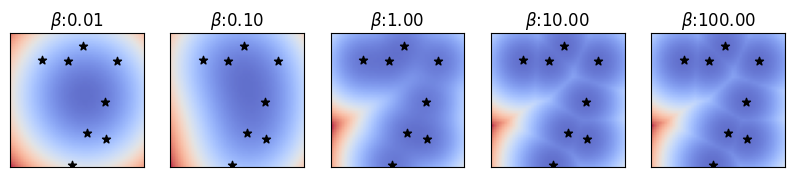

In [9]:
betas = [0.01, 0.1, 1, 10, 100]
figscaler = 2
fig, axs = plt.subplots(
    1, len(betas), figsize=(
        len(betas) * figscaler, 
        figscaler
    ),
    sharex=True, sharey=True
)
beta_en_map = {}
for b, ax in tqdm(
    zip(betas, axs), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    en = np.zeros_like(V[0])
    for i, j in product(range(nsteps), range(nsteps)):
        en[i,j] = lse_energy(V[:, i, j], Xi, b)
    beta_en_map[b] = en
    plot_energy_landscape(
        en, ax, np.array([xmin, xmax, ymin, ymax])
    )
    plot_states(Xi, ax, marker='*', color=MCOLOR)
    ax.set_title(r"$\beta$" + f":{b:0.2f}")
plt.show()

### Minimizing the Energy via Gradient Descent 

For an initial state vector $\mathbf{q} \in \mathbb{R}^D$, we can minimize its energy utilizing the energy gradient. Initializing the energy descent at the $\mathbf{q}$, that is $\mathbf{v}^{(0)} \gets \mathbf{q}$, we perform the following gradient descent steps for $T$ iterations:
$$
\mathbf{v}^{(t)} \gets \mathbf{v}^{(t-1)} - \alpha \nabla_{\mathbf{v}} E_\beta( \mathbf{v}^{(t-1)}; \boldsymbol{\Xi} ), 
$$
for $t = 1, \ldots, T$ with $\alpha > 0$ as the step-size (or learning rate) for the energy descent. The final $\mathbf{v}^{(T)}$ is the output of the model.

We can implement this using auto-differentiation in JAX by computing the gradient of the `lse_energy` function with respect to its input `state`.

In [10]:
def lse_energy_descent( 
    q: Float[Array, "D"],
    memories: Float[Array, "K D"],
    beta,
    energy_fn,
    depth: int=10,
    alpha: float = 0.01,
    return_grads=False,
    clamp_idxs: Optional[Bool[Array, "D"]]=None
) -> Float[Array, "D"]: 
    """Energy descent with the LSE energy"""
    # en = lambda state: energy_fn(state, memories, beta) 
    dEdxf = jax.jit(jax.value_and_grad(energy_fn))
    logs = {}
    def step(x, i):
        E, dEdx = dEdxf(x, memories, beta)
        if clamp_idxs is not None:
            dEdx = jnp.where(clamp_idxs, 0, dEdx)
        x = x - alpha * dEdx
        aux = (E, dEdx) if return_grads else (E,)
        return x, aux
    x, aux = jax.lax.scan(step, q, jnp.arange(depth))
    logs['energies'] = aux[0]
    if return_grads:
        logs['grads'] = aux[1]
    return x, logs

#### Energy Descent with the LSE Energy

As an example, we will use the previous set of memories to perform the energy descent for a randomly generated query $\mathbf{q} \in \mathbb{R}^D$ using the above function `lse_energy_descent`. We will note the intermediate states $\mathbf{v}^{(0)}, \ldots, \mathbf{v}^{(T)}$, and the energy $E_\beta(\mathbf{v}^{(t)}; \boldsymbol{\Xi}), t \in [\![ T ]\!]$ at each layer of the DenseAM (equivalently, the energy at each iteration of the energy gradient descent).

In the following example, the number of DenseAM layers (equivalently, the number of energy descent steps) is set at $T = 1000$, and we use a step-size $\alpha = 0.01$. We will plot the intermediate states at every `NUPDATES=25` layers.

100%|███████████████| 5/5 [00:08<00:00,  1.80s/it]


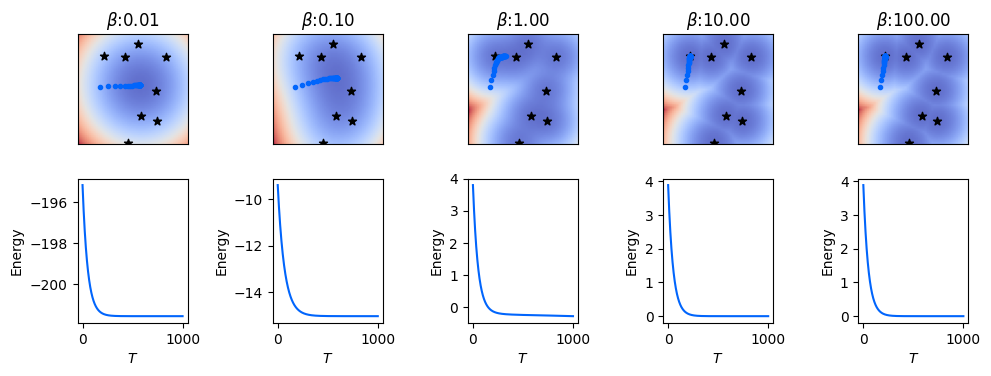

In [11]:
NSTATES = 40
NUPDATES = 25
ALPHA = 0.01
rngidx = 7
fig, axs = plt.subplots(
    2, len(betas), figsize=(
        len(betas) * figscaler, 
        2 * figscaler
    ),
    sharex="row",
)
beta_true_states_en_map = {}
for bidx, b in tqdm(
    enumerate(betas), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    # Randomly generating a query
    query = jr.uniform(
        rnglist[rngidx], (D, )
    ) * 2 * maxabs - maxabs
    qstates = [query]
    qens = []
    # Perform energy descent
    for i in range(NSTATES):
        query, logs = lse_energy_descent(
            query, Xi, b, lse_energy,
            depth=NUPDATES, alpha=ALPHA
        )
        qstates += [query]
        qens += [logs['energies']]
    plot_energy_landscape(
        beta_en_map[b], axs[0, bidx],
        np.array([xmin, xmax, ymin, ymax])
    )
    plot_states(
        Xi, axs[0, bidx],
        marker='*', color=MCOLOR
    )
    axs[0, bidx].set_title(r"$\beta$" + f":{b:0.2f}")
    qstates = np.array(qstates)
    plot_states(
        qstates, axs[0, bidx],
        marker='.', color=QCOLOR
    )
    qens = np.array(qens).reshape(-1)
    plot_energy_descent(
        qens, axs[1, bidx], color=QCOLOR
    )
    beta_true_states_en_map[b] = (qstates, qens)
fig.tight_layout()
plt.show()

## Viewing Energy as a Kernel Sum

It is easy to see that the aforemention energy function can be viewed as a _kernel sum_. Specifying a kernel function $\kappa: \mathbb{R}^D \times \mathbb{R}^D \to \mathbb{R}$ such that $\kappa(\mathbf{x}, \mathbf{x}') = \exp(-\frac{1}{2} \Vert \mathbf{x} - \mathbf{x}' \Vert^2 )$, the _radial basis function_ or RBF kernel, we can reduce the energy function to a kernel sum as follows:
\begin{align}
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) 
& = - \frac{1}{\beta} \log \sum_{\mu = 1}^K \underbrace{
  \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right)
}_{\kappa(\sqrt{\beta}\mathbf{v}, \sqrt{\beta}\boldsymbol{\xi}^\mu)}
\\ 
& = - \frac{1}{\beta} \log \sum_{\mu = 1}^K \kappa \left(\sqrt{\beta}\mathbf{v}, \sqrt{\beta}\boldsymbol{\xi}^\mu \right),
\end{align}

In general, we need to keep around all the memories $\boldsymbol{\Xi} = \left\{ \boldsymbol{\xi}^\mu \in \mathbb{R}^D, \mu \in [\![ K ]\!] \right\}$ to compute this kernel sum, and thus the energy function.

### Simplifying the Kernel Sum with Random Features

However, if there exists a feature map $\Phi: \mathbb{R}^D \to \mathbb{R}^Y$, such that, the dot-product in this feature space approximates the kernel function as follows: 
$$
\kappa(\mathbf{x}, \mathbf{x}') \approx \left\langle \Phi(\mathbf{x}), \Phi(\mathbf{x}') \right\rangle,
$$
then the kernel sum can be simplified as (dropping the $\beta$ for now)
\begin{align}
\sum_{\mu = 1}^K \kappa(\mathbf{v}, \boldsymbol{\xi}^\mu) 
& \approx \sum_{\mu = 1}^K \left\langle \Phi(\mathbf{v}), \Phi(\boldsymbol{\xi}^\mu) \right\rangle
\\
& = \left\langle \Phi(\mathbf{v}), \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu) \right\rangle
\\
& = \left\langle \Phi(\mathbf{v}), \mathbf{T} \right\rangle, \qquad \text{where} \quad 
\mathbf{T} = \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu).
\end{align}
In this case, we need to compute the vector $\mathbf{T} \in \mathbb{R}^Y$ using all the $K$ memories $\left\{ \boldsymbol{\xi}^\mu, \mu \in [\![ K ]\!] \right\}$ **just once**, and then use $\mathbf{T}$ for all subsequent kernel sum approximation without needing access to the original memories.

### Examples of Random Features

Various approximate feature maps have been developed for the RBF kernel. The first feature map proposed by Rahimi & Recht (2007) utilizes random features and trigonometric function. More recently, Choromanski et al. (2021) have proposed positive random features utilizing the exponential function. Both these random features are presented below, where $\mathcal{N}(0, \mathbf{I}_D)$ is the $D$-dimensional multivariate isotropic standard normal distribution:

$$
\Phi(\mathbf{x}) = \frac{1}{\sqrt{Y}} \left[ \begin{array}{c}
  \cos \langle \boldsymbol{\omega}^1, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^1, \mathbf{x} \rangle \\
  \cos \langle \boldsymbol{\omega}^2, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^2, \mathbf{x} \rangle \\
  \cdots \\
  \cos \langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle \\
\end{array}\right], 
\qquad 
\Phi(\mathbf{x}) = \frac{1}{\sqrt{Y}} \left[ \begin{array}{c}
  \exp (+\langle \boldsymbol{\omega}^1, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^1, \mathbf{x} \rangle) \\
  \exp (+\langle \boldsymbol{\omega}^2, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^2, \mathbf{x} \rangle) \\
  \cdots \\
  \exp (+\langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle) \\
\end{array}\right], 
\quad
\boldsymbol{\omega}^i \sim \mathcal{N}(0, \mathbf{I}_D), i \in [\![ Y ]\!].
$$

> Rahimi A. and Recht B. 2007. **Random Features for Large-scale Kernel Machines**. _Advances in Neural Information Processing Systems_. [[paper]](https://proceedings.neurips.cc/paper/2007/file/013a006f03dbc5392effeb8f18fda755-Paper.pdf)
> Choromanski K., Likhosherstov V., Dohan D., Song X., Gane A., Sarlos T., Hawkins P., Davis J., Mohiuddin A., Kaiser L., Belanger D., Colwell, L. and Weller, A. 2021. **Rethinking Attention with Performers**. _Proceedings of the International Conference on Learning Representations_. [[paper]](https://openreview.net/pdf?id=Ua6zuk0WRH)

Note that both these random features generate $2Y$-dimensional feature map $\Phi(\mathbf{x}) \in \mathbb{R}^{2Y}$ with $Y$ random features $\boldsymbol{\omega}^i, i \in [\![ Y ]\!]$. We implement the random features with trigonometric functions below.

In [12]:
def sin_cos_phi(
    x: Float[Array, "... D"],
    RF: Float[Array, "Y D"],
    beta: float
) -> Float[Array, "... 2Y"]:
    # print(x.shape, RF.shape)
    """Random features with trigonometric function"""
    Y = RF.shape[0]
    h = jnp.sqrt(beta) * (x @ RF.T)
    return 1 / jnp.sqrt(Y) * jnp.concatenate(
        [ jnp.cos(h), jnp.sin(h)], axis=-1
    )

#### Approximating the Kernel Value

Here we will visualize the quality of the kernel value approximations obtained with the trigonometric random features with $Y = 10^6$. We randomly generate samples $\mathbf{x} \in \mathbb{R}^D$ from the domain, and compare their kernel values with the memories $\boldsymbol{\xi}^\mu$. That is, we compare the true RBF kernel value $\kappa(\sqrt{\beta}\mathbf{x}, \sqrt{\beta}\boldsymbol{\xi}^\mu) = \exp(-\frac{\beta}{2} \Vert \mathbf{x} - \boldsymbol{\xi}^\mu \Vert^2)$ to approximated kernel value using the random features $\left\langle \Phi(\sqrt{\beta}\mathbf{x}), \sqrt{\beta}\Phi(\boldsymbol{\xi}^\mu) \right\rangle$ for different values of $\beta$, $\mu \in [\![ K ]\!]$ and different random samples $\mathbf{x}$.

In the following, we compute the RBF kernel $\kappa(\sqrt{\beta}\mathbf{x}, \sqrt{\beta}\boldsymbol{\xi}^\mu) = \exp(-\frac{\beta}{2} \Vert \mathbf{x} - \boldsymbol{\xi}^\mu \Vert^2)$.

In [13]:
def rbfkernel(
    x: Float[Array, "D"],
    y: Float[Array, "D"],
    beta: float,
) -> Float[Array, ""]:
    """Compute the standard RBF kernel between two vectors."""
    return jnp.exp(-0.5 * beta * ((x - y) ** 2).sum())

Here we generate $Y=10^6$ random features for the memories $\boldsymbol{\Xi}$ using the `sin_cos_phi` function.

In [14]:
Y = 1_000_000
rngidx = 4
RF = jr.normal(rnglist[rngidx], (Y, D))
phi_Xi = sin_cos_phi(Xi, RF, 1.0)

Now we generate `NRANDS` random $\mathbf{x} \in \mathbb{R}^D$ and compare their exact and approximate kernel values with the memories.

100%|███████████████| 5/5 [00:15<00:00,  3.04s/it]


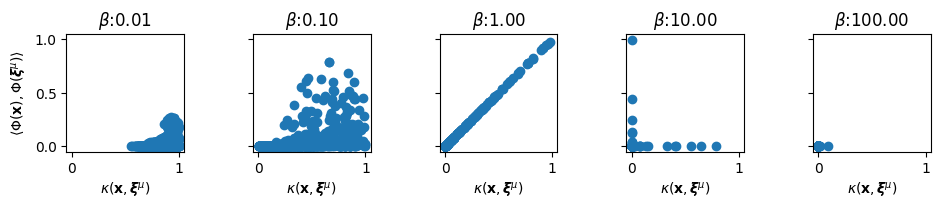

In [15]:
rngidx = 9
NRANDS = 100
rxs = jr.uniform(
    rnglist[rngidx], (NRANDS, D)
) * 2 * maxabs - maxabs

fig, axs = plt.subplots(
    1, len(betas), figsize=(
        len(betas) * figscaler, 
        figscaler
    ),
    sharex=True, sharey=True
)
for b, ax in tqdm(
    zip(betas, axs), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    phi_rxs = sin_cos_phi(rxs, RF, b)
    true_kvals = np.array([rbfkernel(x, y, b) for x in rxs for y in Xi])
    approx_kvals = np.array([x.dot(y) for x in phi_rxs for y in phi_Xi])
    ax.scatter(true_kvals, approx_kvals)
    ax.set_xlabel(r"$\kappa(\mathbf{x}, \boldsymbol{\xi}^\mu)$")
    ax.set_title(r"$\beta$" + f":{b:0.2f}")
    ax.axis('square')
axs[0].set_ylabel(r"$\langle \Phi(\mathbf{x}), \Phi(\boldsymbol{\xi}^\mu) \rangle$")
fig.tight_layout()
plt.show()

In the above figure, a good approximation would put all the points in the scatter plots on the diagonal. Based on these figures, we make the following observations with a fixed value of $D, Y$:
- Small values of $\beta$ push the RBF kernel values close to 1, and the random features do not approximate these values well.
- As $\beta$ grows, the approximation quality improves, with $\beta = 1$ producing really good approximation of the exact kernel values.
- When $\beta$ increases beyond a point, most pairwise RBF kernel values go close to zero, and approximation quality again falls.

Note that overall performance will continue to improve as the ratio $D/Y$ decreases for any given value of $\beta$.

#### Visualizing the Random Features

Here we visualize the first `NRFS=6` of the random features across the data domain for varying values of $\beta$. The use of the trigonometric function is visible through the periodic nature of these random features, where larger values of $\beta$ lead to shorter periods.

100%|███████████████| 5/5 [00:00<00:00, 10.23it/s]


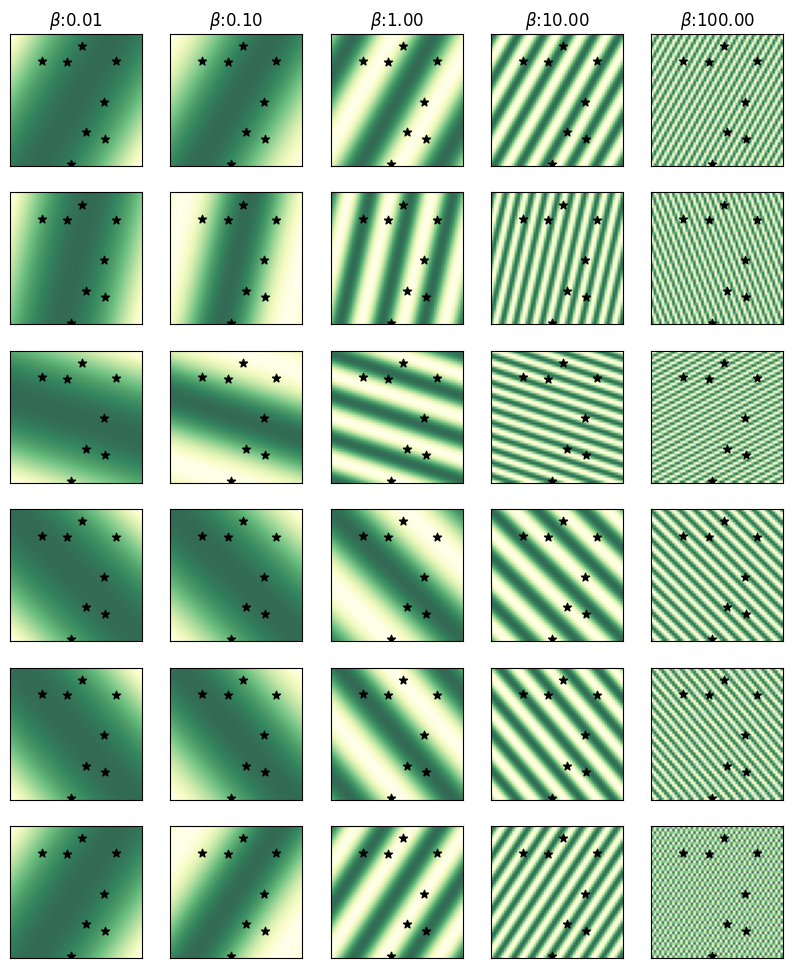

In [16]:
NRFS = 6
fig, axs = plt.subplots(
    NRFS, len(betas), figsize=(
        len(betas) * figscaler, 
        NRFS * figscaler
    ),
    sharex=True, sharey=True
)
for bidx, b in tqdm(
    enumerate(betas), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    rfs = np.zeros([2*NRFS, V.shape[1], V.shape[2]])
    for i in range(nsteps):
        rfs[:, i, :] = sin_cos_phi(V[:, i, :].T, RF[:NRFS, :], b).T
    for i in range(NRFS):
        plot_energy_landscape(
            rfs[i, :, :], axs[i, bidx], 
            np.array([xmin, xmax, ymin, ymax]),
            colormap='YlGn'
        )
        plot_states(Xi, axs[i, bidx], marker='*', color=MCOLOR)
    axs[0, bidx].set_title(r"$\beta$" + f":{b:0.2f}")
    # break
plt.show()

## Approximating the Energy with Random Features

Given the random features $\Phi: \mathbb{R}^D \to \mathbb{R}^{2Y}$, we can approximate the energy as
\begin{align}
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) 
& = - \frac{1}{\beta} \log \sum_{\mu = 1}^K
  \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right)
\\
& \approx \sum_{\mu = 1}^K \left\langle \Phi(\mathbf{v}), \Phi(\boldsymbol{\xi}^\mu) \right\rangle
= \left\langle \Phi(\mathbf{v}), \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu) \right\rangle
\\
& = \left\langle \Phi(\mathbf{v}), \mathbf{T} \right\rangle
= \tilde{E}_\beta(\mathbf{v}, \mathbf{T}), \qquad \text{with} \quad 
\mathbf{T} = \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu).
\end{align}

We implement this approximate energy below using random features below given the $\{ \boldsymbol{\omega}^i, i \in [\![ Y ]\!] \}$ and the aggregated memories $\mathbf{T} \in \mathbb{R}^{2Y}$.


In [17]:
def approx_lse_energy(
    x: Float[Array, "D"],
    RF: Float[Array, "Y D"],
    beta: float,
    T: Float[Array, "2Y"],
    eps=1e-10
) -> Float[Array, ""]:
    """Compute the approx energy with random features"""
    h = sin_cos_phi(x, RF, beta) @ T 
    h = jnp.clip(h,  a_min=eps)
    return -(1 / beta) * jnp.log(h)

Here we compare the exact energy landscape to energy landscape approximated with random features for varying values of $\beta$ given the set of memories $\boldsymbol{\Xi}$. For a given value of $\beta$, we first compute $\mathbf{T} = \sum_{\mu=1}^K \Phi(\sqrt{\beta} \boldsymbol{\xi}^\mu )$, and the use it to compute the approximate energy landscape.

100%|███████████████| 5/5 [01:46<00:00, 21.22s/it]


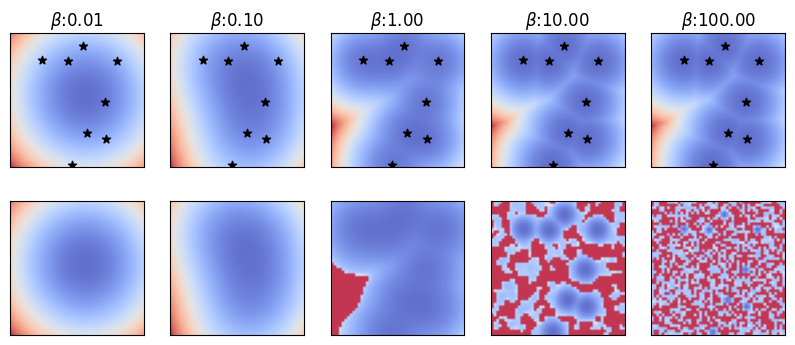

In [18]:
fig, axs = plt.subplots(
    2, len(betas), figsize=(
        len(betas) * figscaler, 
        2 * figscaler
    ),
    sharex=True, sharey=True
)
for bidx, b in tqdm(
    enumerate(betas), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    # Computing the T tensor, 
    # summing the random features over all memories
    T_Xi = sin_cos_phi(Xi, RF, b).sum(0)
    # Computing the approx energy over the domain
    app_en = np.zeros_like(V[0])
    for i in range(nsteps):
            app_en[i, :] = approx_lse_energy(
                V[:, i, :].T, RF, b, T_Xi
            )
    # Plotting the exact and approx energy
    plot_energy_landscape(
        beta_en_map[b], axs[0, bidx],
        np.array([xmin, xmax, ymin, ymax])
    )
    plot_states(
        Xi, axs[0, bidx],
        marker='*', color=MCOLOR
    )
    plot_energy_landscape(
        app_en, axs[1, bidx],
        np.array([xmin, xmax, ymin, ymax])
    )
    axs[0, bidx].set_title(r"$\beta$" + f":{b:0.2f}")
plt.show()

For small values of $\beta$, the exact and approximate energy landscapes appear visually similar. However, for larger values of $\beta$, the energy landscapes start differing significantly, especially farther away from the memories. However, note how the approximate energy still forms a local minima around each of the original memories even though the actual basins of attraction of this approximate energy are significantly smaller.

### Approximate Energy Descent

In [19]:
assert False

AssertionError: 

In [ ]:
class DrDAM:
    """Defines the interface and basic methods for all KernelizableDAMs"""
    def __init__(self, key, D, Y, beta):
        self.RF = jr.normal(key, (Y, D))
        self.beta = beta
        self.Y = Y
        self.Tdim = 2*Y
        self.D = D

    def phi(self, x: Float[Array, "... D"]) -> Float[Array, "... 2Y"]:
        """Compute the basis function """
        return sin_cos_phi(x, self.RF, self.beta)

    def sim(self, x: Float[Array, "D"], y: Float[Array, "D"]) -> Float[Array, ""]:
        """Compute the standard L2 similarity between two vectors."""
        return jnp.exp(-self.beta / 2 * ((x - y) ** 2).sum())

    def energy(
        self, x: Float[Array, "D"], memories: Float[Array, "M D"]
    ) -> Float[Array, ""]:
        """Compute the standard L2 energy"""
        return -(1 / self.beta) * jax.nn.logsumexp(
            -self.beta / 2 * ((x - memories) ** 2).sum(-1), axis=0
        )

    def kernel_energy(
        self, x: Float[Array, "D"], T: Float[Array, "2Y"], eps=1e-10
    ) -> Float[Array, ""]:
        """Compute the approximate kernelized energy"""
        h = self.phi(x) @ T 
        h = jnp.clip(h,  a_min=eps)
        return -(1 / self.beta) * jnp.log(h)
    
    def kernel_sim(
        self, x: Float[Array, "D"], y: Float[Array, "D"]
    ) -> Float[Array, ""]:
        """Compute the approximate kernel similarity of `x` and `y`"""
        return self.phi(x) @ self.phi(y)

    def kernelize_memories(self, memories: Float[Array, "M D"], **kwargs) -> Float[Array, "2Y"]:
        """
        Naive implementation that BLOWS UP with many memories `n`,
        since it creates the entire memory matrix from scratch
        """
        return self.phi(memories).sum(0)

    def recall( 
        self, q: Float[Array, "D"], memories: Float[Array, "M D"], 
        depth: int=1000, alpha: float = 0.1, return_grads=False, 
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Using the normal similarity function, run energy dynamics"""
        dEdxf = jax.jit(jax.value_and_grad(self.energy))
        logs = {}
        def step(x, i):
            E, dEdx = dEdxf(x, memories)
            if clamp_idxs is not None:
                dEdx = jnp.where(clamp_idxs, 0, dEdx)
            x = x - alpha * dEdx
            aux = (E, dEdx) if return_grads else (E,)
            return x, aux
        x, aux = jax.lax.scan(step, q, jnp.arange(depth))
        logs['energies'] = aux[0]
        if return_grads:
            logs['grads'] = aux[1]
        return x, logs

    def kernel_recall(
        self, q: Float[Array, "D"], T: Float[Array, "2Y"], 
        depth: int=1000, alpha: float = 0.1, return_grads=False,
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Using the kernelized similarity function, run energy dynamics"""
        dEdxf = jax.jit(jax.value_and_grad(self.kernel_energy))
        logs = {}
        @jax.jit
        def step(x, i):
            E, dEdx = dEdxf(x, T)
            if clamp_idxs is not None:
                dEdx = jnp.where(clamp_idxs, 0, dEdx)
            x = x - alpha * dEdx
            aux = (E, dEdx) if return_grads else (E,)
            return x, aux
        x, aux = jax.lax.scan(step, q, jnp.arange(depth))
        logs['energies'] = aux[0]
        if return_grads:
            logs['grads'] = aux[1]
        return x, logs

In [ ]:
rng = jr.PRNGKey(0)
k1, k2, k3, k4, k5, rng = jr.split(rng, 6)
D = 10
Y = 1000
n_memories = 20
n_queries = 100
beta = 10
kdam = DrDAM(k1, D=D, Y=Y, beta=beta)

In [ ]:
x = (jr.uniform(k2, (D,)) > 0.5) / jnp.sqrt(D)
y = (jr.uniform(k3, (D,)) > 0.5) / jnp.sqrt(D)
print(x.shape)
print(y.shape)

In [ ]:
print(kdam.sim(x, y))
print(kdam.kernel_sim(x, y))

In [ ]:
memories = (jr.uniform(k4, (n_memories, D)) > 0.5) / jnp.sqrt(D)
queries = (jr.uniform(k5, (n_queries, D)) > 0.5) / jnp.sqrt(D)
print(queries.shape, memories.shape)
T = kdam.kernelize_memories(memories)
print(T.shape)

In [ ]:
print(kdam.energy(x, memories))
print(kdam.kernel_energy(x, T))

In [ ]:
exact_energies = jnp.array([kdam.energy(q, memories).item() for q in queries])
kernelized_energies = kdam.kernel_energy(queries, T)
plt.scatter(exact_energies, kernelized_energies)
plt.xlabel("Exact")
plt.ylabel("Kernel")
plt.axis('square')
# plt.gca().set_aspect('equal', 'box')
plt.show()

In [ ]:
exact_out, _ = kdam.recall(queries[0], memories, depth=100, alpha=1)
kernel_out, _ = kdam.kernel_recall(queries[0], T, depth=100, alpha=1)
print(jnp.abs(exact_out - kernel_out).sum())